<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jimmyliao/BwAI2025/blob/main/06_FoodCaloriesEntry.ipynb"><img src="https://ai.google.dev/site-assets/images/docs/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Food Calories Entry: Upload, Analysis

### Prerequist
1. Create your own spreadsheet

  1.1. Should have `Food Name`, `Calories`, `Timestamp` on the first row
  
  1.2. Get the Spreadsheet ID from URL


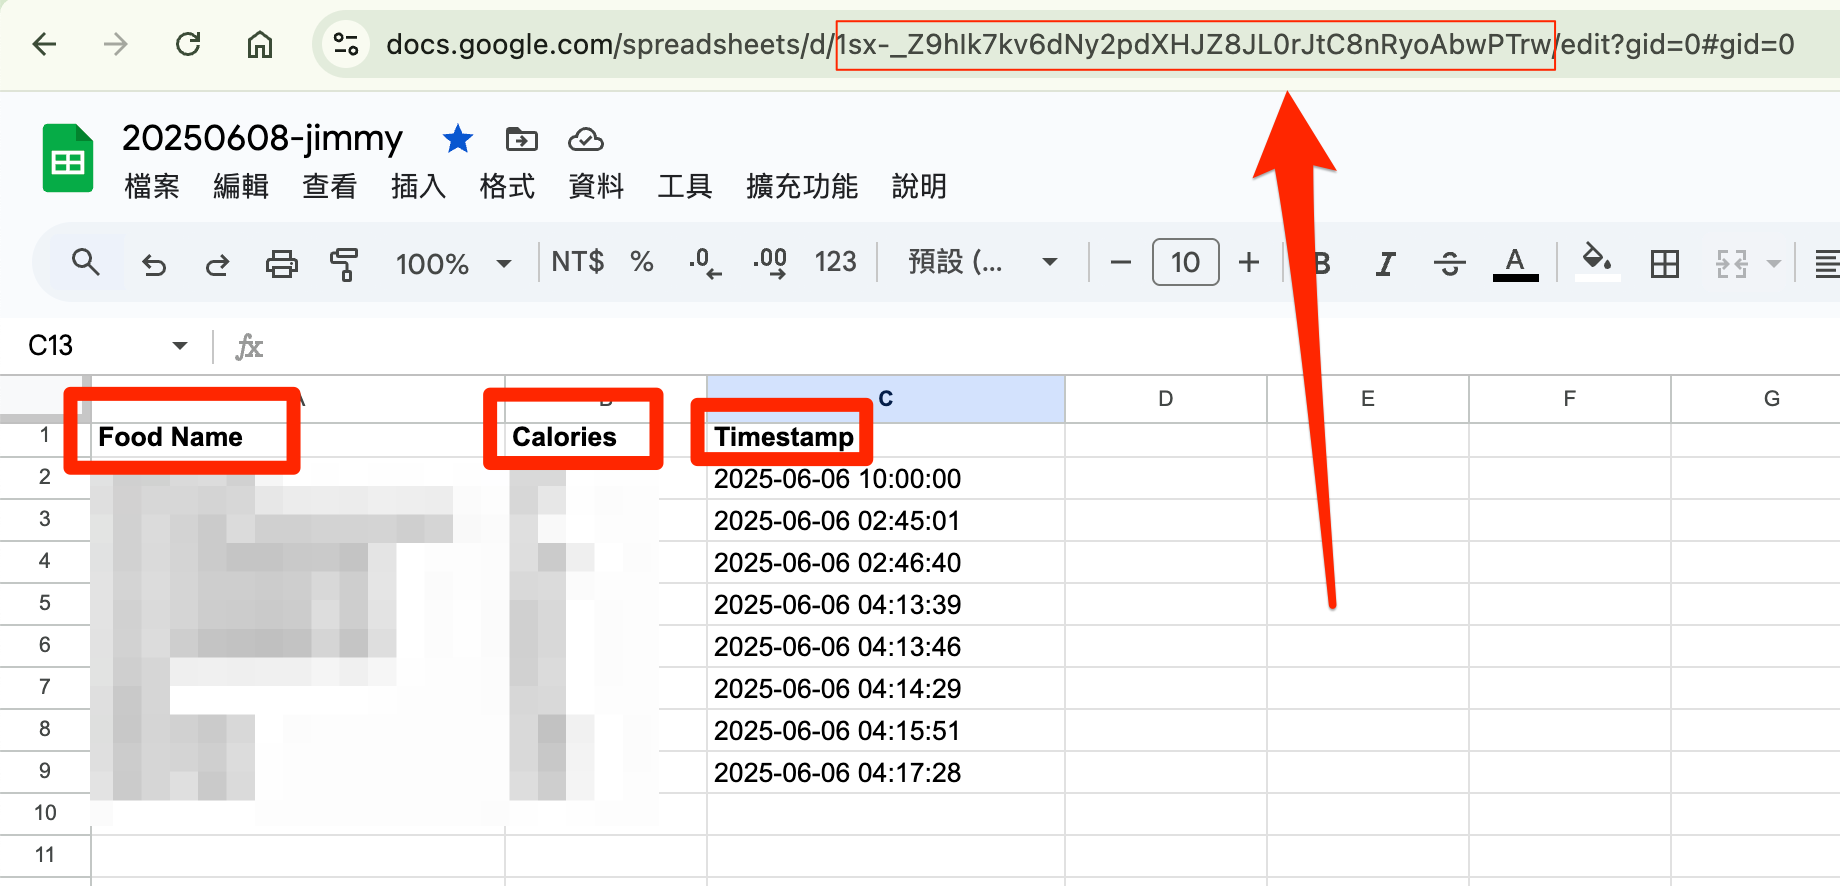

2. Enable `GOOGLE_API_KEY` from the Colab secret, create one if empty

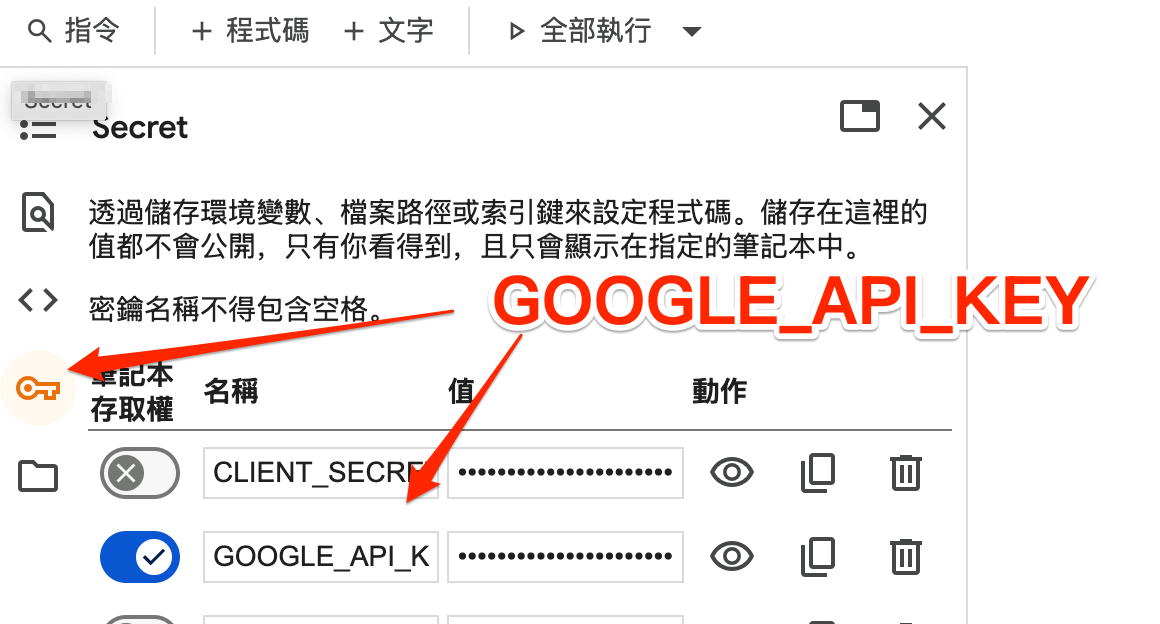


### Tips: Use prompt to create the code snippet with Gemini Code Assist

1. Click Gemini Code Assist button and input the prompt

2. Click `Enter` simply

#### Example prompt
```text
請幫我利用 google.colab sheet 讀取 https://docs.google.com/spreadsheets/d/1sx-_Z9hIk7kv6dNy2pdXHJZ8JL0rJtC8nRyoAbwPTrw/edit?gid=0#gid=0
# 其中會有三個欄位 Food Name, Calories, Timestamp, 嘗試先讀取現有內容並顯示, 並先寫入一筆範例, 然後顯示所有
```

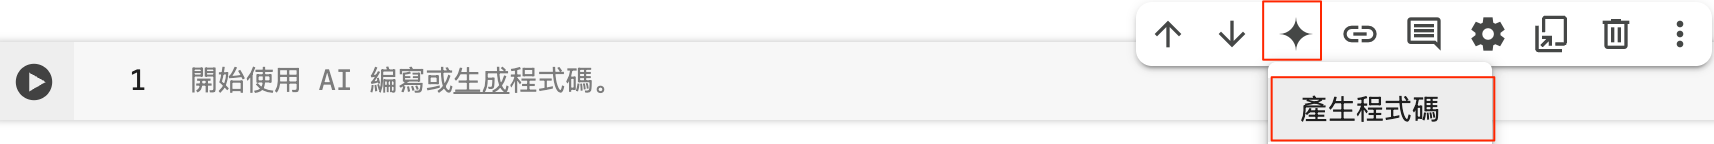


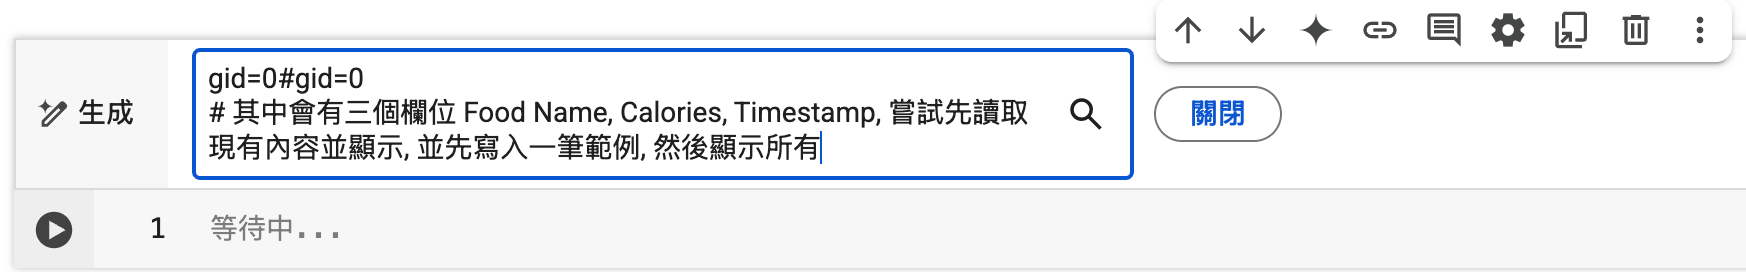

## Now Begin to Build with Gemini 😏

In [20]:
# prompt: 請幫我利用 google.colab sheet 讀取 https://docs.google.com/spreadsheets/d/1sx-_Z9hIk7kv6dNy2pdXHJZ8JL0rJtC8nRyoAbwPTrw/edit?gid=0#gid=0
# 其中會有三個欄位 Food Name, Calories, Timestamp, 嘗試先讀取現有內容並顯示, 並先寫入一筆範例, 然後顯示所有

!pip install --upgrade -q gspread

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# Replace '1sx-_Z9hIk7kv6dNy2pdXHJZ8JL0rJtC8nRyoAbwPTrw' with the actual spreadsheet ID
spreadsheet_id = '1sx-_Z9hIk7kv6dNy2pdXHJZ8JL0rJtC8nRyoAbwPTrw'
worksheet = gc.open_by_key(spreadsheet_id).sheet1

# Read and display existing content
print("Existing content:")
list_of_rows = worksheet.get_all_values()
for row in list_of_rows:
    print(row)

# # Write a sample row
# sample_row = ["Sample Food", "150", "2025-06-06 10:00:00"]
# worksheet.append_row(sample_row)


Existing content:
['Food Name', 'Calories', 'Timestamp']
['Sample Food', '150', '2025-06-06 10:00:00']
['Food_2025_06_06_02_45_01', '77', '2025-06-06 02:45:01']
['Food_20250606024640', '1473', '2025-06-06 02:46:40']


In [22]:
# prompt: 定義一個函式，寫入 food_entry

def add_food_entry(food_name, calories):
  """Adds a new food entry to the Google Sheet.

  Args:
    food_name: The name of the food.
    calories: The number of calories in the food.
  """
  current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  row = [food_name, str(calories), current_time]
  worksheet.append_row(row)
  print(f"Added entry: {row}")

# Example usage:
# add_food_entry("Banana", 100)


In [26]:
# prompt: 讀取現有時間，寫入一筆範例, Food Name 應該與時間戳記有關, 熱量為隨機數字, 透過 add_food_entry

import datetime
import random

current_time = datetime.datetime.now()
food_name = f"Food_{current_time.strftime('%Y%m%d%H%M%S')}"  # Food Name based on timestamp
calories = random.randint(50, 2500)  # Random calorie number

add_food_entry(food_name, calories)

Added entry: ['Food_20250606041339', '436', '2025-06-06 04:13:39']


In [17]:
# prompt: 定義一個 function, 使用 Google GenAI SDK (pypi: google-genai) 判斷上傳的圖片是否為食物照片, 如果是的話分析熱量與食物內容, 回傳出來的值分別是 Food name 和 Calories。模型使用 gemini-2.5-flash-preview-05-20。

!pip install -q -U google-genai
# import google.generativeai as genai
from google import genai
from google.genai import types
import PIL.Image
import json

# Configure your API key (replace with your actual API key or use environment variable)
# You can get an API key from https://makersuite.google.com/
# For Colab, it's often recommended to use user secrets.
import google.colab.userdata as userdata
# API_KEY = userdata.get('GOOGLE_API_KEY')
# genai.configure(api_key=API_KEY)

# For simplicity in this example, you can directly put your API key here if you are comfortable
# with that for testing purposes, but it's not recommended for production.
# API_KEY = "YOUR_GOOGLE_API_KEY"
# genai.configure(api_key=API_KEY)

# As per best practices in Colab, let's use the environment variable approach
import os
# Ensure you have set the GOOGLE_API_KEY environment variable in Colab secrets

# Get Google API key from Colab secrets
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

if 'GOOGLE_API_KEY' not in os.environ:
  print("Please set the GOOGLE_API_KEY environment variable in Colab secrets.")
  # You would typically stop execution here or handle it appropriately
  # For demonstration, we'll proceed with a placeholder, but it won't work without the key
  os.environ['GOOGLE_API_KEY'] = 'YOUR_PLACEHOLDER_API_KEY' # Replace with your actual key if not using secrets

client = genai.Client(api_key=os.environ['GOOGLE_API_KEY'])


def analyze_food_image(image_path):
  """
  Analyzes an image to determine if it's food and estimates its calories.

  Args:
    image_path: The path to the image file.

  Returns:
    A tuple containing (food_name, calories) if it's food, otherwise (None, None).
  """
  try:
    img = PIL.Image.open(image_path)
  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    return None, None
  except Exception as e:
    print(f"Error opening image: {e}")
    return None, None


  # model = genai.GenerativeModel('gemini-1.5-flash-latest') # Using 1.5 Flash which is generally better for multimodal

  model = 'gemini-2.5-flash-preview-05-20'

  prompt = """
  Analyze the following image.
  First, determine if the image contains food.
  If it contains food, estimate the main food item name and its approximate calorie count.
  Provide the output in a simple JSON format with two keys: "Food name" and "Calories".
  If it does not contain food, return {"Food name": null, "Calories": null}.
  Only return the JSON object, no other text.
  """

  try:
    response = client.models.generate_content(
        model=model,
        contents=[
            img,
            prompt
        ])
    print(response.text)

# ```json
# {
#   "Food name": "Steak Platter",
#   "Calories": 1700
# }
# ```
# Response json, need to 1) remove ```json and last ``` , 2) abstract the food name and calories and return them as a tuple
    response_json = json.loads(response.text.replace("```json", "").replace("```", ""))

    print(response_json)
    food_name = response_json.get("Food name")
    calories = response_json.get("Calories")

    return food_name, calories

  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    return None, None
  except Exception as e:
    print(f"Error opening image: {e}")
    return None, None


In [28]:
# Example usage with a sample image: uploaded_photo.jpg

food_name, calories = analyze_food_image('uploaded_photo.jpg')

if food_name and calories:
  print(f"Identified Food: {food_name}")
  print(f"Estimated Calories: {calories}")

# 寫入 spreadsheet

if food_name and calories:
  print(f"Identified Food: {food_name}")
  print(f"Estimated Calories: {calories}")
  # Add the identified food and calories to the spreadsheet
  add_food_entry(food_name, calories)

```json
{
  "Food name": "Steak",
  "Calories": 700
}
```
{'Food name': 'Steak', 'Calories': 700}
Identified Food: Steak
Estimated Calories: 700
Identified Food: Steak
Estimated Calories: 700
Added entry: ['Steak', '700', '2025-06-06 04:14:29']


In [ ]:
# prompt: 在 Colab 定義一個按鈕，可以上傳照片並且預覽.

import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab import files
from PIL import Image
import io

def upload_and_preview(change):
  """Handles file upload and displays the preview."""
  clear_output(wait=True) # Clear previous output
  upload_button = widgets.FileUpload(accept='image/*', multiple=False)
  upload_button.observe(upload_and_preview, names='value')
  display(upload_button)

  if change.new:
    uploaded_file_name = next(iter(change.new))
    uploaded_file_content = change.new[uploaded_file_name]['content']

    print(f"Uploaded file: {uploaded_file_name}")

    # Display image preview
    try:
      img = Image.open(io.BytesIO(uploaded_file_content))
      display(img)

      # Optionally, you can save the image to a file in the Colab runtime
      # with open(uploaded_file_name, 'wb') as f:
      #   f.write(uploaded_file_content)
      # print(f"Image saved to {uploaded_file_name}")

      # Now you can use the image_file_name to call analyze_food_image
      # For this example, we'll just print the filename.
      # In a real application, you would need to save the file locally
      # to use with analyze_food_image, or modify analyze_food_image
      # to accept bytes.
      print(f"Image data available. You can process it with analyze_food_image after saving locally if needed.")

    except Exception as e:
      print(f"Error displaying image: {e}")


# Create the initial upload button
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
# Observe changes in the uploaded value to trigger the function
upload_button.observe(upload_and_preview, names='value')

print("Click the button to upload an image:")
display(upload_button)


In [ ]:
# prompt: 將照片儲存，並分析食物名稱與熱量
import ipywidgets as widgets
from IPython.display import display, clear_output
from google.colab import files
from PIL import Image
import io


def upload_and_analyze(change):
  """Handles file upload, saves the image, analyzes it, and adds to sheet."""
  clear_output(wait=True) # Clear previous output

  # Re-display the upload button for the next upload
  upload_button = widgets.FileUpload(accept='image/*', multiple=False)
  upload_button.observe(upload_and_analyze, names='value')
  display(upload_button)

  if change.new:
    uploaded_file_name = next(iter(change.new))
    uploaded_file_content = change.new[uploaded_file_name]['content']

    print(f"Uploaded file: {uploaded_file_name}")

    # Display image preview
    try:
      img = Image.open(io.BytesIO(uploaded_file_content))
      display(img)

      # Save the image to a file in the Colab runtime to be used by analyze_food_image
      local_image_path = uploaded_file_name
      with open(local_image_path, 'wb') as f:
        f.write(uploaded_file_content)
      print(f"Image saved to {local_image_path}")

      # Analyze the saved image
      food_name, calories = analyze_food_image(local_image_path)

      if food_name and calories:
        print(f"Identified Food: {food_name}")
        print(f"Estimated Calories: {calories}")
        # Add to the spreadsheet
        add_food_entry(food_name, calories)
      else:
        print("The image does not appear to be food or could not be analyzed.")

      # Clean up the local image file (optional)
      # os.remove(local_image_path)

    except Exception as e:
      print(f"Error processing image: {e}")


# Create the initial upload button
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
# Observe changes in the uploaded value to trigger the function
upload_button.observe(upload_and_analyze, names='value')

print("Click the button to upload an image for analysis:")
display(upload_button)


In [ ]:
# prompt: 將照片儲存, 分析食物名稱與熱量, 存回 spreadsheet, 需要顯示已經上傳檔案, 分析好檔案, 寫入 spreadsheet

def upload_analyze_and_sheet(change):
  """Handles file upload, saves, analyzes image, adds to sheet, and shows progress."""
  clear_output(wait=True) # Clear previous output

  # Re-display the upload button for the next upload
  upload_button = widgets.FileUpload(accept='image/*', multiple=False)
  upload_button.observe(upload_analyze_and_sheet, names='value')
  display(upload_button)

  if change.new:
    uploaded_file_name = next(iter(change.new))
    uploaded_file_content = change.new[uploaded_file_name]['content']

    print(f"Status: Uploaded file: {uploaded_file_name}")

    # Display image preview
    try:
      img = Image.open(io.BytesIO(uploaded_file_content))
      display(img)

      # Save the image to a file in the Colab runtime to be used by analyze_food_image
      local_image_path = uploaded_file_name
      with open(local_image_path, 'wb') as f:
        f.write(uploaded_file_content)
      print(f"Status: Image saved locally to {local_image_path}")

      print("Status: Analyzing image...")
      # Analyze the saved image
      food_name, calories = analyze_food_image(local_image_path)

      if food_name and calories:
        print(f"Status: Analysis complete. Identified Food: {food_name}, Estimated Calories: {calories}")
        print("Status: Writing to spreadsheet...")
        # Add to the spreadsheet
        add_food_entry(food_name, calories)
        print("Status: Data written to spreadsheet.")
      else:
        print("Status: The image does not appear to be food or could not be analyzed.")

      # Clean up the local image file (optional)
      # try:
      #   os.remove(local_image_path)
      #   print(f"Status: Cleaned up local file {local_image_path}")
      # except OSError as e:
      #   print(f"Error removing file {local_image_path}: {e}")


    except Exception as e:
      print(f"Error processing image: {e}")


# Create the initial upload button
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
# Observe changes in the uploaded value to trigger the function
upload_button.observe(upload_analyze_and_sheet, names='value')

print("Click the button to upload an image for analysis:")
display(upload_button)
